In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow_addons as tfa


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [53]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization


from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import glob
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50



In [6]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    '''takes in true values and predicted values.
    The function then prints out a classifcation report
    as well as a confusion matrix using seaborn's heatmap.'''
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    print(classification_report(y, y_hat, target_names=['NORMAL', 'PNEUMONIA']))
    print('Accurancy: ', accuracy)
    sns.heatmap(cm,  cmap= 'Greens', annot=True)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title(title)
    plt.show()

In [3]:
def show_img(train_images, train_labels):
    plt.figure(figsize=(12,12))
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(train_images[i])
        if train_labels[i]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NORMAL')
        plt.axis('off')

### Group parameters for train and test data generators the entire group is using for this project

In [4]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, 
                                                             zoom_range=0.2,
                                                             rescale=1./225)
val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
train_data = train_datagen.flow_from_directory('data/chest_xray/train/',
                                               target_size=(100,100),
                                               batch_size=32,
                                               class_mode='binary',
                                               color_mode='grayscale')
val_data = val_datagen.flow_from_directory('data/chest_xray/val/',
                                               target_size=(100,100),
                                               batch_size=32,
                                               class_mode='binary',
                                               color_mode='grayscale')
test_data = test_datagen.flow_from_directory('data/chest_xray/test//',
                                             target_size=(100,100),
                                             batch_size=32,
                                             class_mode='binary',
                                             color_mode='grayscale')

Found 5216 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
train_images, train_labels = next(iter(train_data))
train_img = train_images.reshape(train_images.shape[0], -1)

def show_img(train_images, train_labels):
    plt.figure(figsize=(12,12))
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(train_images[i])
        if train_labels[i]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NORMAL')
        plt.axis('off')

In [54]:
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

In [23]:
model = Sequential()
model.add(Convolution2D(32, (3,3), input_shape=(100,100,1), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(units=110, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ])

history = model.fit(train_data, epochs=30, validation_data=(val_data))

Epoch 1/30
163/163 [==============================] - 54s 332ms/step - loss: 0.4844 - accuracy: 0.7788 - precision: 0.7419 - recall: 0.8973 - val_loss: 0.4319 - val_accuracy: 0.8750 - val_precision: 0.7867 - val_recall: 0.9640
Epoch 2/30
163/163 [==============================] - 55s 337ms/step - loss: 0.3062 - accuracy: 0.8829 - precision: 0.8124 - recall: 0.9662 - val_loss: 0.4248 - val_accuracy: 0.8750 - val_precision: 0.8327 - val_recall: 0.9666
Epoch 3/30
163/163 [==============================] - 56s 342ms/step - loss: 0.2428 - accuracy: 0.9011 - precision: 0.8473 - recall: 0.9631 - val_loss: 0.3075 - val_accuracy: 0.9167 - val_precision: 0.8602 - val_recall: 0.9599
Epoch 4/30
163/163 [==============================] - 55s 337ms/step - loss: 0.2060 - accuracy: 0.9153 - precision: 0.8696 - recall: 0.9585 - val_loss: 0.2731 - val_accuracy: 0.9167 - val_precision: 0.8778 - val_recall: 0.9578
Epoch 5/30
163/163 [==============================] - 54s 333ms/step - loss: 0.1834 - accura

In [24]:
acc = model.evaluate_generator(test_data, steps=len(test_data), verbose=1)
list(zip(model.metrics_names, acc))

20/20 [==============================] - 4s 205ms/step


[('loss', 1.0372339487075806),
 ('accuracy', 0.8846153616905212),
 ('precision', 0.9517831802368164),
 ('recall', 0.9671846628189087)]

In [25]:
first_batch = test_data.next()
data_list = first_batch[0]
batch_index = 0
class_list = first_batch[1]
while batch_index <= test_data.batch_index:
    data = test_data.next()
    print(data[0].shape)
    data_list=np.concatenate((data_list, data[0]))
    class_list=np.concatenate((class_list, data[1]))
    batch_index = batch_index + 1
data_array = np.asarray(data_list)
data_array.shape

(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(32, 100, 100, 1)
(16, 100, 100, 1)


(624, 100, 100, 1)

In [27]:
preds = model.predict_classes(data_array)

              precision    recall  f1-score   support

      NORMAL       0.97      0.71      0.82       234
   PNEUMONIA       0.85      0.99      0.91       390

    accuracy                           0.88       624
   macro avg       0.91      0.85      0.87       624
weighted avg       0.90      0.88      0.88       624

Accurancy:  0.8846153846153846


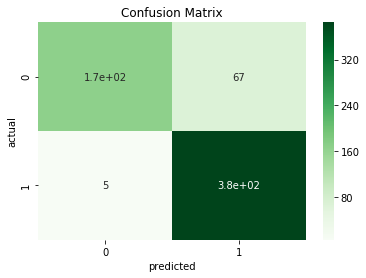

In [29]:
evaluation(class_list, preds)

#### Achieving an accuracy score of .88 on the hold out test data was better than we expected for a baseline model. I am going to try adding a normalization layer.

In [41]:
model = Sequential()
model.add(Convolution2D(32, (3,3), input_shape=(100,100,1), activation='relu'))
#Group Normalization Layer
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(units=110, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ])

history = model.fit(train_data, epochs=30,  validation_data=(val_data))

Epoch 1/30
163/163 [==============================] - 73s 446ms/step - loss: 0.4006 - accuracy: 0.8800 - precision: 0.8773 - recall: 0.8659 - val_loss: 0.5438 - val_accuracy: 0.6667 - val_precision: 0.9168 - val_recall: 0.9206
Epoch 2/30
163/163 [==============================] - 74s 451ms/step - loss: 0.1759 - accuracy: 0.9317 - precision: 0.9283 - recall: 0.9317 - val_loss: 0.5542 - val_accuracy: 0.7083 - val_precision: 0.9349 - val_recall: 0.9372
Epoch 3/30
163/163 [==============================] - 72s 443ms/step - loss: 0.1763 - accuracy: 0.9314 - precision: 0.9388 - recall: 0.9406 - val_loss: 0.7491 - val_accuracy: 0.6667 - val_precision: 0.9410 - val_recall: 0.9423
Epoch 4/30
163/163 [==============================] - 73s 447ms/step - loss: 0.1410 - accuracy: 0.9471 - precision: 0.9437 - recall: 0.9459 - val_loss: 0.3281 - val_accuracy: 0.7917 - val_precision: 0.9460 - val_recall: 0.9485
Epoch 5/30
163/163 [==============================] - 72s 444ms/step - loss: 0.1342 - accura

              precision    recall  f1-score   support

      NORMAL       0.91      0.78      0.84       234
   PNEUMONIA       0.88      0.96      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624

Accurancy:  0.8894230769230769


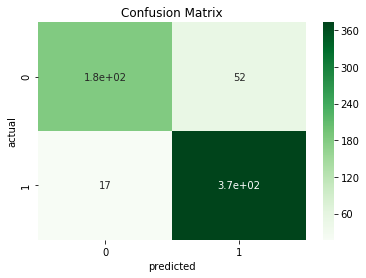

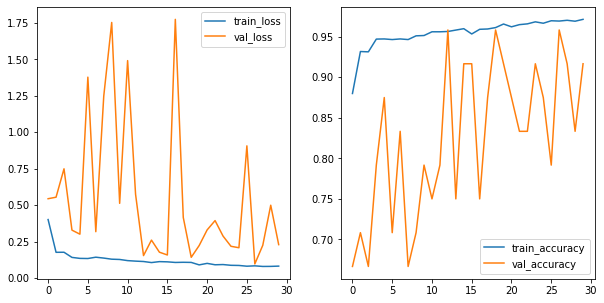

In [49]:
preds2 = model.predict_classes(data_array)
evaluation(class_list, preds2)

train_loss = model.history.history['loss']
train_acc = model.history.history['accuracy']
val_loss = model.history.history['val_loss']
val_acc = model.history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(history.epoch, val_acc, ax=ax2, label='val_accuracy')

In [50]:
acc = model.evaluate_generator(test_data, steps=len(test_data), verbose=1)
list(zip(model.metrics_names, acc))

20/20 [==============================] - 5s 239ms/step


[('loss', 0.3413003087043762),
 ('accuracy', 0.8894230723381042),
 ('precision', 0.9691228866577148),
 ('recall', 0.9690080881118774)]

In [120]:
pip install keras-resnet

  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=4242d50ca9d5f223b7d6a501777148b0c1bb1d860abd8762b024b83700bbe6db
  Stored in directory: /Users/JasonWong/Library/Caches/pip/wheels/9c/e1/ab/1b35bf1600303ed3255d015ed61d064132e163386a94045081
Successfully built keras-resnet
Note: you may need to restart the kernel to use updated packages.


In [96]:
transfer_train_datagen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, 
                                                             zoom_range=0.2,
                                                             rescale=1./225)
transfer_val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
transfer_test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
transfer_train_data = transfer_train_datagen.flow_from_directory('data/chest_xray/train/',
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='binary')
                                               #color_mode='grayscale')
transfer_val_data = transfer_val_datagen.flow_from_directory('data/chest_xray/val/',
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='binary')
                                               #color_mode='grayscale')
transfer_test_data = transfer_test_datagen.flow_from_directory('data/chest_xray/test//',
                                             target_size=(224,224),
                                             batch_size=32,
                                             class_mode='binary')
                                             #color_mode='grayscale')

Found 5216 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Converting train images to RGB

In [105]:
batch_3 = transfer_train_data.next()
data_list = batch_3[0]
batch_index = 0
class_list = batch_3[1]
while batch_index <= transfer_train_data.batch_index:
    data = transfer_train_data.next()
    data_list=np.concatenate((data_list, data[0]))
    class_list=np.concatenate((class_list, data[1]))
    batch_index = batch_index + 1
transfer_data_train = np.asarray(data_list)


In [106]:
transfer_data_train.shape

(5216, 224, 224, 3)

In [178]:
train_image_RGB = np.ndarray(shape=(transfer_data_train.shape[0], transfer_data_train.shape[1], transfer_data_train.shape[2], 3), dtype= np.uint8) 


In [179]:
train_image_RGB.shape

(5216, 224, 224, 3)

### Converting validation images to RGB

In [107]:
batch_4 = transfer_val_data.next()
data_list = batch_4[0]
batch_index = 0
class_list = batch_4[1]
while batch_index <= transfer_val_data.batch_index:
    data = transfer_val_data.next()
    print(data[0].shape)
    data_list=np.concatenate((data_list, data[0]))
    class_list=np.concatenate((class_list, data[1]))
    batch_index = batch_index + 1
transfer_data_val = np.asarray(data_list)

(24, 224, 224, 3)


In [182]:
val_image_RGB = np.ndarray(shape=(transfer_data_val.shape[0], transfer_data_val.shape[1], transfer_data_val.shape[2], 3), dtype= np.uint8) 
val_image_RGB.shape

(48, 224, 224, 3)

In [101]:
transfer_model.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 50, 50, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 50, 50, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 50, 50, 32)   0           stem_bn[0][0]                    
____________________________________________________________________________________

In [170]:
train_image_RGB.shape

(5120, 224, 224, 3)

### Defining the files for pnemonia and normal for training

In [8]:
tr_train_files = glob.glob('data/chest_xray/train/PNEUMONIA/*'),  glob.glob('data/chest_xray/train/NORMAL/*')

train_files_pneumonia = glob.glob('data/chest_xray/train/PNEUMONIA/*')
train_files_normal = glob.glob('data/chest_xray/train/NORMAL/*')


### Adding NORMAL images with the PNEUMONIA images

tr_train_files[0].extend(tr_train_files[1])

tr_train_imgs = [img_to_array(load_img(img)) for img in tr_train_files[0]]
tr_train_imgs = np.array(tr_train_imgs)



In [9]:
tr_train_labels = [fn.split('\\')[-1].split('.')[0].strip() for fn in tr_train_files[0]]

tr_train_labels = [x[22] for x in tr_train_labels]

### Defining the files for pnemonia and normal for validation

In [10]:
val_files_pneumonia = glob.glob('data/chest_xray/val/PNEUMONIA/*')
val_files_normal = glob.glob('data/chest_xray/val/NORMAL/*')

val_pneumonia = [x for x in val_files_pneumonia]
val_normal = [x for x in val_files_normal]

In [11]:
tr_val_files = glob.glob('data/chest_xray/val/PNEUMONIA/*'), glob.glob('data/chest_xray/val/NORMAL/*'), 'rb'
tr_val_files[0].extend(tr_val_files[1])

In [12]:
tr_val_imgs = [img_to_array(load_img(img)) for img in tr_val_files[0]]

In [13]:
type(tr_val_imgs)

list

In [14]:
tr_val_labels = [fn.split('\\')[-1].split('.')[0].strip() for fn in tr_val_files[0]]

tr_val_labels = [x[20] for x in tr_val_labels]

In [42]:
le = LabelEncoder()
tr_train_labels_encoded = le.fit_transform(tr_train_labels)
tr_val_labels_encoded = le.transform(tr_val_labels)

In [58]:
tr_val_labels_encoded

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

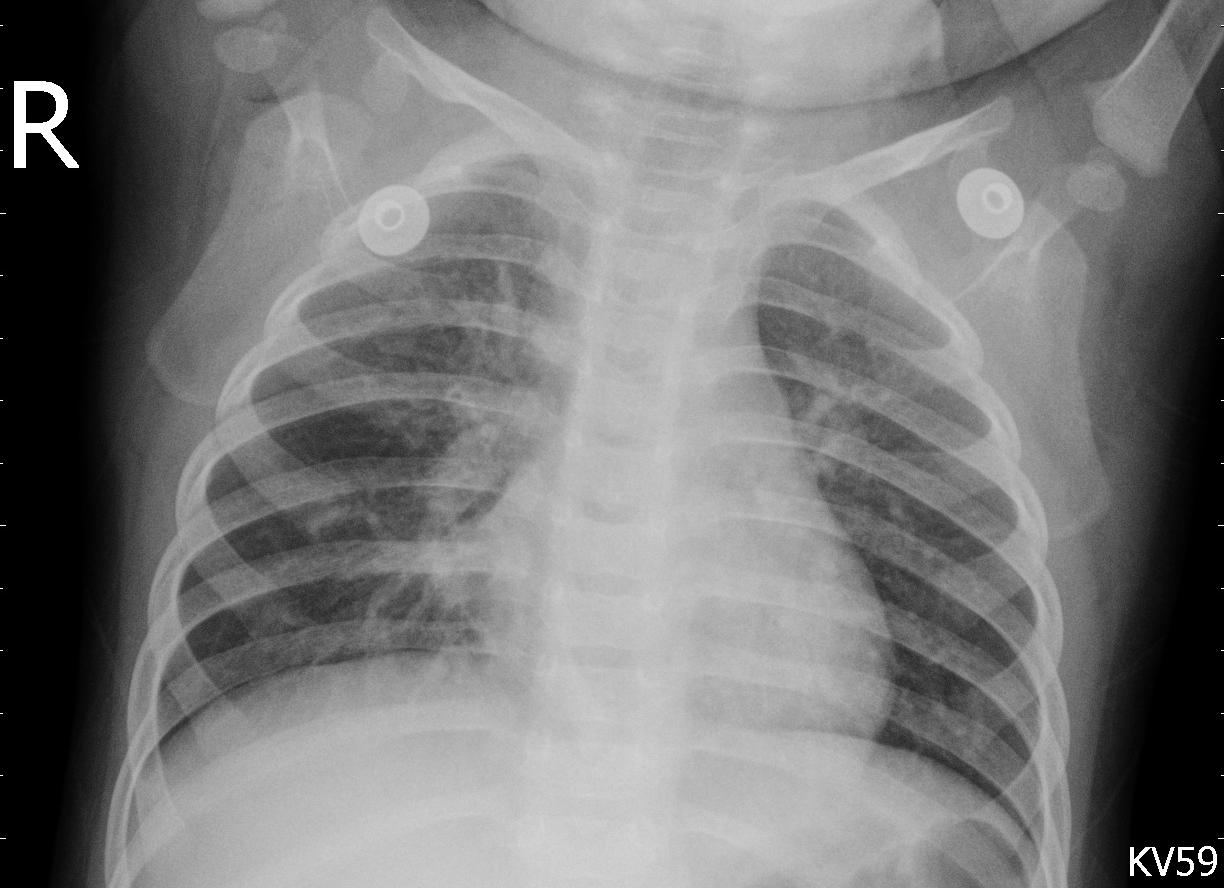

In [61]:
array_to_img(tr_train_imgs[3])

### Attempt with resnet50

In [116]:
base_model = ResNet50(include_top=False, weights='imagenet')

In [104]:
transfer_train_datagen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, 
                                                             zoom_range=0.2,
                                                             rescale=1./225)
transfer_val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
transfer_test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
transfer_train_data = transfer_train_datagen.flow_from_directory('data/chest_xray/train/',
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='binary')
                                               #color_mode='grayscale')
transfer_val_data = transfer_val_datagen.flow_from_directory('data/chest_xray/val/',
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='binary')
                                               #color_mode='grayscale')
transfer_test_data = transfer_test_datagen.flow_from_directory('data/chest_xray/test//',
                                             target_size=(224,224),
                                             batch_size=32,
                                             class_mode='binary')
                                             #color_mode='grayscale')

Found 5216 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [118]:
base_model.trainable=False

In [69]:
from keras.models import Model, optim

In [71]:
img_width=224
img_height=224
img_dim = (img_width, img_height)
input_shape=(img_height, img_width, 3)

In [120]:
transfer_model_head = Sequential()
transfer_model_head.add(base_model)
#transfer_model_head.add(Convolution2D(32, (3,3), input_shape=(100,100, 1), activation='relu'))
#Batch Normalization Layer
#transfer_model_head.add(BatchNormalization())
#transfer_model_head.add(MaxPooling2D(2,2))
#transfer_model_head.add(Flatten())
transfer_model_head.add(Dense(60, activation='relu', input_dim=input_shape))
transfer_model_head.add(Dense(1, activation='sigmoid'))
transfer_model_head.compile(optimizer='Adam', loss='binary_crossentropy', metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ])

transfer_history = transfer_model_head.fit(transfer_data_train, epochs=30, validation_data=(transfer_data_val))

Epoch 1/30


ValueError: in user code:

    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:541 train_step  **
        self.trainable_variables)
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1804 _minimize
        trainable_variables))
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:521 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1219 _filter_grads
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['dense_72/kernel:0', 'dense_72/bias:0', 'dense_73/kernel:0', 'dense_73/bias:0'].
